Question: Is there a better measure of success than yards gained?

Historically it has been thought that the best way to measure how efficient a football team is to look at how many yards a team gained or allowed to be gained. This way of looking at team efficiency is good, but not the best way becuase not all yards are created equally. For example, A 4-yard gain on 3rd & 2 is much more valuable than a 4-yard gain on 3rd & 16. Those four yards gained lack context. With this project, I will attempt to give context to those 4 yards gained. 

      - There is a statistic/metric in football named Expected Points Added (EPA). This metric attempts to measure the impact of one play on the outcome of the game. Explanation of EPA: For further explanation of EPA see the following link: https://www.advancedfootballanalytics.com/index.php/home/stats/stats-explained/expected-points-and-epa-explained)
      
A few things of note:
      - Each play has an EPA value that is calculated by finding the difference between the Expected Points before the play happens and the Expected Points after the play happens.
      - My goal is to create an Expected Points model for college football to measure the effectiveness/efficiency of an individual play. After completing the model, each play will have an EPA value. We can then look at the average EPA per play for each team and see which teams have more efficient offenses/defenses. 
        - The target is the 'next points scored'. There are possible values of: +/-7, +/-3, and +/-2. I will have to add this variable to the data set. 
   

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

DATA CLEANING AND EDA

I got the data from an R package called cfbscrapR (see https://saiemgilani.github.io/cfbscrapR/). I used the R package to get the data of every play that happened in the 2018 and 2019 college football seasons. This package does have an EPA model of their own, however I will not use that model and create my own version. The data is relatively clean, but needed multiple variables/features added to the data. I created a list below of all the features that I created to complete the model. I also ran into a few issues with some of the variables that I had to clean up or filter some of the plays out. I took the liberty of not including kickoffs or punts into my model becuase I could not come up with a good way of incorperating the change of possession into the model. 

In [2]:
#import data
pbp18 = pd.read_csv('pbp2018.csv', encoding='ISO-8859-1')
pbp19 = pd.read_csv('pbp2019.csv', encoding='ISO-8859-1')
drives18 = pd.read_csv('drives_18.csv', encoding='ISO-8859-1')
drives19 = pd.read_csv('drives_19.csv', encoding='ISO-8859-1')

C:\Users\nathd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (146,147,150,151) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#get relevant variables from data frames -- note: the original data has the statistic I am trying to compute but I will not include it in the data I will work with
pbp19 = pbp19[['week', 'game_id', 'drive_id', 'offense_play', 'defense_play', 'half', 'period', 'clock.minutes', 'clock.seconds', 'play_type', 'play_text', 'down', 'distance', 'yards_to_goal', 'yards_gained', 'offense_score', 'defense_score', 'down_end', 'distance_end', 'drive_result', 'offense_conference', 'home', 'away', 'yards_to_goal_end']]
pbp18 = pbp18[['week', 'game_id', 'drive_id', 'offense_play', 'defense_play', 'half', 'period', 'clock.minutes', 'clock.seconds', 'play_type', 'play_text', 'down', 'distance', 'yards_to_goal', 'yards_gained', 'offense_score', 'defense_score', 'down_end', 'distance_end', 'drive_result', 'offense_conference', 'home', 'away', 'yards_to_goal_end']]
pbp20 = pbp20[['week.x', 'game_id', 'drive_id', 'offense_play', 'defense_play', 'half', 'period', 'clock.minutes', 'clock.seconds', 'play_type', 'play_text', 'down', 'distance', 'yards_to_goal', 'yards_gained', 'offense_score', 'defense_score', 'down_end', 'distance_end', 'drive_result', 'offense_conference', 'home', 'away', 'yards_to_goal_end']]

In [5]:
#combine play by play data from 2018 and 2019 seasons, add needed columns from drive data sets -- should I add 2020??
pbp = pbp18.append(pbp19)
drives = drives18.append(drives19)[['drive_id', 'offense', 'defense', 'scoring']]

pbp = pbp.merge(drives, how = 'inner', on = 'drive_id')

In [6]:
# # # BASIC DATA CLEANING -- filter out bad plays / adding a few features
pbp = pbp.reset_index(drop = True)

#filter out weird plays that don't make sense
pbp.query('down > 0 & down < 5', inplace = True)
pbp.query('play_type != "placeholder"', inplace = True)
pbp.query('play_type != "Coin Toss"', inplace = True)
pbp.query('play_type != "Timeout"', inplace = True)

In [7]:
#add dummy variables for possible filters
pbp['pass'] = np.where(pbp.play_text.str.lower().str.contains("pass|sack"), 1, 0)
pbp['rush'] = np.where(pbp.play_text.str.lower().str.contains("rush|run"), 1, 0)
pbp['penalty'] = np.where(pbp.play_text.str.lower().str.contains("penalty"), 1, 0)
pbp['punt'] = np.where(pbp.play_text.str.lower().str.contains("punt"), 1, 0)
pbp['kickoff'] = np.where(pbp.play_text.str.lower().str.contains("kickoff|return"), 1, 0)

In [8]:
#Add feature -- success rate -- to use when predicting points per possession
#Used Percentages from SportsSource Analytics
#Football Outsiders uses: 1st - .5, 2nd - .7, 3rd/4th - conversion
pbp['success'] = np.where((pbp.down == 1) & (pbp.yards_gained >= (.4*pbp.distance)), 1, 
                   np.where((pbp.down == 2) & (pbp.yards_gained >= (.5*pbp.distance)), 1,
                   np.where(((pbp.down == 3) | (pbp.down == 4)) & (pbp.yards_gained >=pbp.distance), 1, 0)))

In [9]:
#filter out kickoffs?? penalties? punts?  -- just filter kickoffs and punts for now. 
#Not exactly sure how to deal with the changes in possession or drive ending plays quite yet
pbp.query('`kickoff` == 0 & `punt` == 0 & `play_text` != "Kickoff"', inplace = True)

In [10]:
#reset index after querying
pbp = pbp.reset_index(drop = True)

In [11]:
#Add feature -- points scored. Add the points scored on a specific play
#look into using 'drive_result' instead of 'play_type'
offensive_td = ['Passing Touchdown', 'Rushing Touchdown', 'Fumble Recovery (Own) Touchdown']
fg = ['Field Goal Good']
defensive_td = ['Interception Return Touchdown', 'Fumble Return Touchdown', 'Missed Field Goal Return Touchdown', 'Blocked Field Goal Touchdown']
safety = ['Safety', 'Penalty (Safety)']
#inintialize list for scores
score = list(range(0, len(pbp)))
#find if there was a score on a specific play
for i in range(0, len(pbp)):
    score[i] = np.where(pbp.play_type[i] in offensive_td, 7, 
             np.where(pbp.play_type[i] in fg, 3,
                np.where(pbp.play_type[i] in defensive_td, -7,
                    np.where(pbp.play_type[i] in safety, -2, 0))))
    
#add score to pbp
pbp['score'] = score

In [12]:
#Add feature -- drive points: add the number of points scored for the whole drive to pbp, not just the singular play
drive_points = pbp.groupby('drive_id').agg(drive_pts = ('score', 'max')).reset_index()
pbp = pbp.merge(drive_points, how = 'inner', on = 'drive_id')

In [13]:
#Add feature -- dummy variable for home/away team on the play/drive -- 1 = home, 2 = away
home_away = np.where(pbp.offense == pbp.home, 1, 2)
pbp['home_away'] = home_away

#Add feature -- dummy variable for home/away score. Indicates if the home/away team scored
scoring_team = np.where(pbp.drive_pts != 0, pbp.home_away, 0)
pbp['scoring_team'] = scoring_team

246789

In [14]:
#Add features -- the next score (the next points scored) and the next score team (the team that scored the next points)

#initialize empty lists
total_score = list(range(0, len(pbp.game_id.unique())))
total_score_team = list(range(0, len(pbp.game_id.unique())))
c = 0
#loop through each game (don't want next points leaking from the next game)
for g_id in (pbp.sort_values(['game_id', 'drive_id']).game_id.unique()):
    #get array of game drive scores (g) and array of game drive scores team (t)
    g = pbp.query('game_id == @g_id').groupby('drive_id').agg(drive_pts = ('score', 'max')).reset_index().drive_pts
    t = pbp.query('game_id == @g_id').groupby('drive_id').agg(scoring_team = ('scoring_team', 'max')).reset_index().scoring_team
    #initialize empty series for each game
    next_score = pd.Series([0]).repeat(len(g)).reset_index(drop = True)
    next_score_team = pd.Series([0]).repeat(len(t)).reset_index(drop = True)
    #count the number of drives in between scores
    counter = 0
    
    #loop through drives in the game
    for i in range(0, len(g)):
        #if the drive is not a score, increment counter
        if g[i] == 0:
            counter = counter + 1
        #if the drive is a score, get the points scored and the team that scored
        else:
            points = g[i]
            team = t[i]
            #if the previous drive was also a score (no need to assign values to past drives)
            if counter == 0:
                next_score[i] = points
                next_score_team[i] = team
            #assign next points for previous scoreless drives
            else:
                #loop through previous scoreless drives
                for j in range(0, counter + 1):
                    next_score[(i - j)] = points
                    next_score_team[(i - j)] = team
                counter = 0
    #add game to big lists           
    total_score[c] = next_score
    total_score_team[c] = next_score_team
    c = c + 1
    #print i to check on how long it takes
    if c in range(0, len(pbp.game_id.unique()), 100):
        print(c)
        
#add next points scored to each drive
next_score_points = pd.Series(total_score).apply(pd.Series).stack().reset_index(drop = True)
drive_p = pbp.sort_values(['game_id', 'drive_id']).groupby(['game_id', 'drive_id']).agg(drive_pts = ('drive_pts', 'max')).reset_index().sort_values(['game_id', 'drive_id'])
drive_p['next_pts'] = next_score_points

#add next points scored team to each drive
next_score_team = pd.Series(total_score_team).apply(pd.Series).stack().reset_index(drop = True)
drive_p['next_pts_team'] = next_score_team

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [15]:
#create new data frame with next points and next points team added
pbp_next = pbp.merge(drive_p[['drive_id', 'next_pts', 'next_pts_team']], how = "inner", on = 'drive_id')

In [16]:
#add feature -- make the next points negative if the next points scored was the other team
true_next_pts = np.where(pbp_next.home_away == pbp_next.next_pts_team, pbp_next.next_pts, (-1)*pbp_next.next_pts)
pbp_next['true_next_pts'] = true_next_pts

In [17]:
#Add feature -- seconds remaining
seconds_remaining = np.where(pbp_next.half == 1, (pbp_next['clock.minutes'] * 60) + pbp_next['clock.seconds'] + (30 * 60), (pbp_next['clock.minutes'] * 60) + pbp_next['clock.seconds'])
pbp_next['seconds_remaining'] = seconds_remaining

In [18]:
#Add feature -- log yards to go
pbp_next['log_yards_to_goal'] = np.where(pbp_next.yards_to_goal <= 0, 0, np.log(pbp_next.yards_to_goal))
pbp_next['log_yards_to_goal_end'] = np.where(pbp_next.yards_to_goal_end <= 0, 0, np.log(pbp_next.yards_to_goal))

C:\Users\nathd\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
#Add feature -- TD, Defensive TD, Safety, and FG dummy variables
pbp_next['td'] = np.where(pbp_next.score == 7, 1, 0)
pbp_next['d_td'] = np.where(pbp_next.score == -7, 1, 0)
pbp_next['saf'] = np.where(pbp_next.score == -2, 1, 0)
pbp_next['fg'] = np.where(pbp_next.score == 3, 1, 0)

In [20]:
#Add features -- before td, before d td, before saf, before fg Dummy Variables (all will be zeros)
zeros = pd.Series(0).repeat(len(pbp_next)).reset_index(drop = True)
pbp_next['td_before'] = zeros
pbp_next['d_td_before'] = zeros
pbp_next['saf_before'] = zeros
pbp_next['fg_before'] = zeros

In [21]:
#clean up yards_to_goal_end for scoring plays
pbp_next['yards_to_goal_end_1'] = pbp_next.yards_to_goal - pbp_next.yards_gained
ytge = np.where(pbp_next.yards_to_goal_end_1 == 0, 0, pbp_next.yards_to_goal_end)
pbp_next['yards_to_goal_end'] = ytge

#fix yards to goal on field goal attempts
yards_gained = np.where(pbp_next.play_type == "Field Goal Good", pbp_next.yards_to_goal,
         np.where(pbp_next.play_type == "Field Goal Missed", 0, pbp_next.yards_gained))
pbp_next['yards_gained'] = yards_gained

#reomve troublesome rows
pbp_next.query('yards_to_goal >= yards_gained', inplace = True)
pbp_next.query('distance_end >= 0', inplace = True)
pbp_next = pbp_next[~pbp_next.isin([np.nan, np.inf, -np.inf]).any(1)]


Features I have added to get to where I need:
    - success
    - score
    - pass
    - rush
    - penalty
    - punt
    - kickoff
    - drive_pts
    - home_away
    - scoring_team
    - next_pts
    - next_pts_team
    - true_next_pts
    - seconds_remaining
    - log_yards_to_goal
    - td and td_before
    - d_td and d_td_before
    - saf and saf_before
    - fg and fg_before
    - yards_to_goal_end
    - log_yards_to_goal_end

In [22]:
#I believe I am done adding features and am ready to start throwing this into models to see which works the best

#model format
pbp_next[['log_yards_to_goal', 'down', 'distance', 'yards_to_goal', 'true_next_pts', 'td', 'd_td', 'saf', 'fg']].head(5)

,log_yards_to_goal,down,distance,yards_to_goal,true_next_pts,td,d_td,saf,fg
0,4.174387,1,10,65,7.0,0,0,0,0
1,4.127134,2,7,62,7.0,0,0,0,0
2,4.219508,3,13,68,7.0,0,0,0,0
3,3.988984,1,10,54,7.0,0,0,0,0
4,3.850148,2,3,47,7.0,0,0,0,0
5,2.944439,1,10,19,7.0,0,0,0,0
6,2.397895,2,2,11,7.0,1,0,0,0
7,4.317488,1,10,75,-7.0,0,0,0,0
8,4.127134,1,10,62,-7.0,0,0,0,0
9,4.043051,2,5,57,-7.0,0,0,0,0


MODELING 
Used a Gradient Boosting Model. I tried the following: ordinary lm, ridge, lasso, knn, random forest, and decistion trees. Gradient Boosting had the best outcomes. I also looked to optimize the max_depth and found an optimal value of 6. 

In [23]:
#import sklearn modeling stuff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [36]:
#split into testing and training sets
y = pbp_next[['true_next_pts']]
X = pbp_next[['log_yards_to_goal', 'down', 'distance', 'yards_to_goal', 'td', 'd_td', 'saf', 'fg']]
#Train/Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=801)

#fit pipeline model -- I tried 6 different types of models and this was the best
gb = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                 ('ss', StandardScaler()),
                 ('gb', GradientBoostingRegressor(max_depth = 6))])
gb.fit(X_train, y_train)
yhat_gb = gb.predict(X_train)
yhat_gb_test = gb.predict(X_test)

C:\Users\nathd\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [37]:
#Try and find best parameters -- commented out becuase it takes a long time to run

#parameters_gb = {'max_depth':list(range(2,15))}
#gb = GradientBoostingRegressor()
#par_gb = GridSearchCV(gb, parameters_gb)
#par_gb.fit(X_train, y_train)

#par_gb.best_params_
#max depth = 6

In [38]:
#test to see mse for training/testing sets
mse_gb_train = mean_squared_error(y_train, yhat_gb)
mse_gb_test = mean_squared_error(y_test, yhat_gb_test)

print(mse_gb_train, mse_gb_test)

25.841422043802602 26.14693604474531


VIEW PREDICTIONS AND EVALUATE HOW THE MODEL DID


In [39]:
#add Expected Points Before and after the play
X_before = pbp_next[['log_yards_to_goal', 'down', 'distance', 'yards_to_goal', 'td_before', 'd_td_before', 'saf_before', 'fg_before']]
X_after = pbp_next[['log_yards_to_goal_end', 'down_end', 'distance_end', 'yards_to_goal_end', 'td', 'd_td', 'saf', 'fg']]

pbp_next['EP_before'] = gb.predict(X_before)
pbp_next['EP_after'] = gb.predict(X_after)

Text(0.5, 1.0, 'Expected Points by Down')

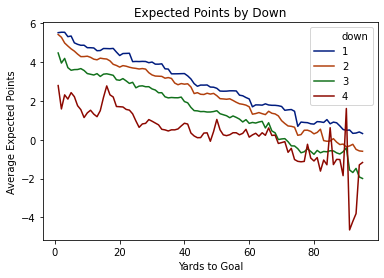

In [100]:
#view expected points values per field position and down
ep_yards_to_goal = pbp_next.query('yards_to_goal < 96').groupby(['down', 'yards_to_goal']).agg(ep = ('EP_before', 'mean')).reset_index()

sns.color_palette("hls", 8)
sns.lineplot(x = ep_yards_to_goal.yards_to_goal, y = ep_yards_to_goal.ep, hue = ep_yards_to_goal.down, palette = sns.color_palette("dark", 4))
plt.xlabel('Yards to Goal')
plt.ylabel('Average Expected Points')
plt.title('Expected Points by Down')

The graphic above shows the expected points before a play occurs grouped by Yards to Goal for each down from each play from my data. This confirms that 1st downs have the highest expected points values. This is how it should be. The fourth downs have a lot of variability mostly due to not having a lot of fourth down data (I filtered out punts and this takes out a wide majority of fourth downs)

In [41]:
#add the differnce in expected points per play = EPA on that play
pbp_next['epa'] = pbp_next.EP_after - pbp_next.EP_before

In [77]:
#add adjusted epa for scoring plays -- the expected points after a score are the value of the score
pbp_next['score_adj_ep_after'] = np.where(pbp_next.score != 0, pbp_next.score, pbp_next.EP_after)
pbp_next['score_adj_epa'] = pbp_next.score_adj_ep_after - pbp_next.EP_before
pbp_next.score_adj_epa = pbp_next.score_adj_epa.astype('float64')

Text(0.5, 1.0, 'FBS Team EPA/play')

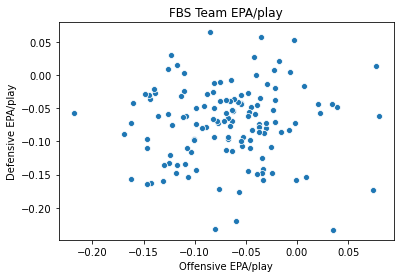

In [45]:
#scatter plot of offensive vs defensive epa/play for all FBS teams
sns.scatterplot(epa_play.off_epa, epa_play.def_epa)
plt.xlabel("Offensive EPA/play")
plt.ylabel("Defensive EPA/play")
plt.title("FBS Team EPA/play")

Text(0.5, 1.0, 'Is Rushing or Passing More Efficient?')

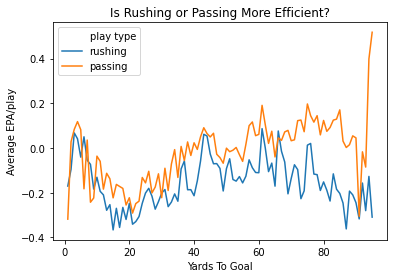

In [81]:
#run vs pass epa -- which is more efficient?

rush_epa = pbp_next.query('rush == 1').groupby('yards_to_goal').agg(rushing = ('epa', 'mean')).reset_index()
pass_epa = pbp_next.query('`pass` == 1').groupby('yards_to_goal').agg(passing = ('epa', 'mean')).reset_index()

pass_rush_epa = rush_epa.merge(pass_epa, how = 'inner', on = 'yards_to_goal')

pass_rush_epa = pd.melt(pass_rush_epa.query('yards_to_goal < 96')[['yards_to_goal', 'rushing', 'passing']], id_vars = ['yards_to_goal'], value_vars = ['rushing', 'passing'], var_name = 'play type', value_name = 'epa')

sns.lineplot(x = pass_rush_epa.yards_to_goal, y = pass_rush_epa.epa, hue = pass_rush_epa['play type'], palette = ["C0", "C1"])
plt.xlabel("Yards To Goal")
plt.ylabel("Average EPA/play")
plt.title("Is Rushing or Passing More Efficient?")

This confirms an expectation of mine that passing plays are more efficient than running plays. As you can see in the graph, the passing plays are above the running plays. 
However, this graphic seemed a little off to me. I would initally believe that the EPA/play would go up as you got closer to the endzone, and this appears to go down. After doing a little digging, I found that on a scoring play, the model was not predicting the scored points properly. The expected points after a scoring play should be the value of a score. If a team scores a Touchdown, the expected points after the play should be 7 (the amount of points scored on the play). I could not get the model to perform better with this, so I added a new variable to the data called score_adj_epa where it changes the scoring plays to have the scoring value from the play. View the plot below to see the difference this makes. 

Text(0.5, 1.0, 'Is Rushing or Passing More Efficient?')

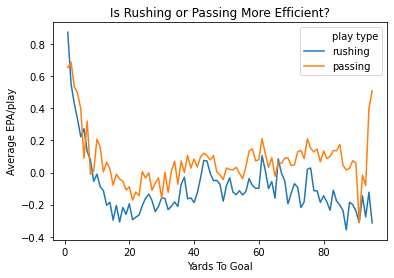

In [166]:
# compare run vs pass using score adjusted epa

rush_epa = pbp_next.query('rush == 1').groupby('yards_to_goal').agg(rushing = ('score_adj_epa', 'mean')).reset_index()
pass_epa = pbp_next.query('`pass` == 1').groupby('yards_to_goal').agg(passing = ('score_adj_epa', 'mean')).reset_index()

pass_rush_epa = rush_epa.merge(pass_epa, how = 'inner', on = 'yards_to_goal')

pass_rush_epa = pd.melt(pass_rush_epa.query('yards_to_goal < 96')[['yards_to_goal', 'rushing', 'passing']], id_vars = ['yards_to_goal'], value_vars = ['rushing', 'passing'], var_name = 'play type', value_name = 'epa')

sns.lineplot(x = pass_rush_epa.yards_to_goal, y = pass_rush_epa.epa, hue = pass_rush_epa['play type'], palette = ["C0", "C1"])
plt.xlabel("Yards To Goal")
plt.ylabel("Average EPA/play")
plt.title("Is Rushing or Passing More Efficient?")

Evaluation
    At the beginning, I made the claim that a 4-yard gain on 3rd & 2 is much more valuable than a 4-yard gain on 3rd & 16. Now it is time to see if the model actually makes this distinction. Below I used the model to create a function that will return the expected points for a given situation. In this case, we want to look at 3rd Down & 2 yards to go before with a 4-yard gain which would result in a 1st Down & 10 yards to go after. I will keep the field position constant and view the expected points added on the play for the scenarios.

3rd and 2 from the 35 yardline -- 4 yard gain
[0.96700026]
3rd and 6 from the 35 yardline -- 4 yard gain
[-0.04301688]
3rd and 12 from the 35 yardline -- 4 yard gain
[-0.95945434]
3rd and 16 from the 35 yardline -- 4 yard gain
[-1.01236479]


Text(0.5, 1.0, 'Expected Points For a Third Down of Given Distance\nAfter a 4-Yard Gain\nFrom the 35 Yard Line')

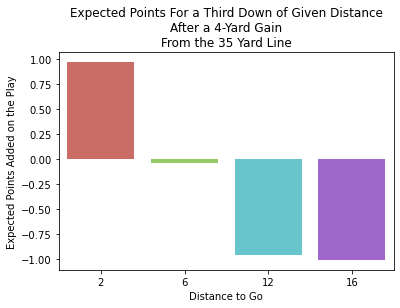

In [173]:
#Does the model give value where value is due?

#define function to get ep values for one play
def ep(dwn, dist, ytg, t_d = 0, dt_d = 0, sfty = 0, f_g = 0):
    play = {'log_yards_to_goal' : [np.log(ytg)], 'down' : [dwn], 'distance' : [dist], 'yards_to_go' : [ytg], 'td' : [t_d], 'd_td' : [dt_d], 'saf' : [sfty], 'fg' : [f_g]}
    return(gb.predict(pd.DataFrame(play)))



#3rd and 2 from the 35 -- 5 yard gain
print("3rd and 2 from the 35 yardline -- 4 yard gain")
a = ep(1, 10, 30, 0, 0, 0, 0) - ep(3, 2, 35, 0, 0, 0, 0)
print(a)
#3rd and 6 from the 35 -- 5 yard gain
print("3rd and 6 from the 35 yardline -- 4 yard gain")
b = ep(4, 2, 30, 0, 0, 0, 0) - ep(3, 6, 35, 0, 0, 0, 0)
print(b)
#3rd and 12 from the 35 -- 5 yard gain
print("3rd and 12 from the 35 yardline -- 4 yard gain")
c = ep(4, 6, 30, 0, 0, 0, 0) - ep(3, 12, 35, 0, 0, 0, 0)
print(c)
#3rd and 16 from the 35 -- 5 yard gain
print("3rd and 16 from the 35 yardline -- 4 yard gain")
d = ep(4, 12, 30, 0, 0, 0, 0) - ep(3, 16, 35, 0, 0, 0, 0)
print(d)

results = pd.DataFrame({'distance' : [2, 6, 12, 16], 'ep' : [a[0], b[0], c[0], d[0]]})

sns.barplot(data = results, x = 'distance', y = 'ep', palette='hls')
plt.xlabel("Distance to Go")
plt.ylabel("Expected Points Added on the Play")
plt.title("Expected Points For a Third Down of Given Distance\nAfter a 4-Yard Gain\nFrom the 35 Yard Line")

The bar graph above shows that the 4-yard gain on 3rd & 2 is much more valuable than a 4-yard gain on 3rd and 16. This confirms that not all yards are created equal and there is a better way to measure success than just total yards. Now we can look at the average epa/play of all teams in college football. below is a chart of the top offenses and then the top defenses in college football. As expected, we see the traditional top teams in these rankings. 

In [192]:
#make data frame of epa/play of FBS teams 
epa_play = pbp_next[pbp_next.offense_conference.notna()].query('`rush` == 1 | `pass` == 1').groupby('offense_play').agg(off_epa = ('score_adj_epa', 'mean')).sort_values('off_epa', ascending = False).reset_index()
epa_play = epa_play.merge(pbp_next[pbp_next.offense_conference.notna()].query('`rush` == 1 | `pass` == 1').groupby('defense_play').agg(def_epa = ('score_adj_epa', 'mean')).sort_values('def_epa', ascending = False).reset_index(), how = 'inner', left_on = 'offense_play', right_on = 'defense_play')

#top defensive teams
epa_play.sort_values('def_epa', ascending = True)[['defense_play', 'def_epa']].reset_index(drop = True).head(10)

,defense_play,def_epa
0,Clemson,-0.211273
1,Miami,-0.195645
2,Michigan,-0.173682
3,Alabama,-0.142236
4,Penn State,-0.139622
5,Missouri,-0.133768
6,Notre Dame,-0.129986
7,San Diego State,-0.124435
8,Wisconsin,-0.124090
9,Michigan State,-0.123130


In [194]:
#top offensive teams
epa_play.sort_values('off_epa', ascending = False)[['offense_play', 'off_epa']].reset_index(drop = True).head(10)

,offense_play,off_epa
0,Oklahoma,0.178043
1,Alabama,0.171099
2,Hawai'i,0.139878
3,Clemson,0.125887
4,Navy,0.108147
5,Air Force,0.108034
6,Memphis,0.104357
7,Ohio State,0.089931
8,Ohio,0.081479
9,Army,0.081005


No handles with labels found to put in legend.


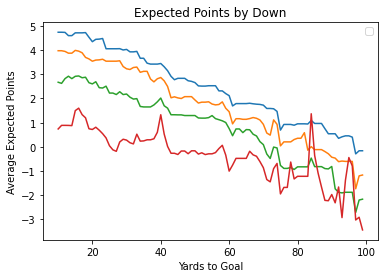

In [154]:
#plot raw model outputs changing down and field position -- not from play by play 
for j in range(1, 5):
    ep_field_position = list(range(10, 100))
    for i in range(10, 100):
        ep_field_position[i - 10] = ep(j, 10, i)[0]
    sns.lineplot(x = range(10, 100), y = ep_field_position)    
plt.xlabel('Yards to Goal')
plt.ylabel('Average Expected Points')
plt.title('Expected Points by Down')